# 데이터 불러오기 및 저장

In [53]:
import tensorflow as tf
import numpy as np
import pandas 
import matplotlib.pylab as plt
import scipy.io

In [54]:
data =  scipy.io.loadmat('./data/notMNIST_small.mat')

In [55]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Aug 10 11:38:32 2011',
 '__version__': '1.0',
 '__globals__': [],
 'images': array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   1.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 215., ...,   0., 160., 124.],
         [255.,   0., 227., ...,   0., 122.,  72.],
         [255.,   0., 156., ...,   0.,   0.,  12.]],
 
        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,  19.,   0., ...,   0.,   0.,   0.],
         [  0.,  93.,   0., ...,   0.,   0.,   0.],
         ...,
         [255.,   0., 255., ...,   0., 255., 255.],
         [255.,   0., 110., ...,   0., 206., 227.],
         [255.,   0.,  21., ...,   0.,   0.,  63.]],
 
        [[  0.,   3.,   0., ...,   0.,   0.,   0.],
         [  0., 167.,   0., ...,   0.,   0.,   0.],
         [  0., 255.,   0., ...,   1.,   1.,   0.],
         ...,
         [255.,   0., 223.

In [56]:
x = data['images']
y = data['labels']

x.shape, y.shape

((28, 28, 18724), (18724,))

In [57]:
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))
print(x.shape)
x = x.reshape( (-1, resolution, resolution, 1) )

# sample, x, y, channel
x.shape, y.shape

(18724, 28, 28)


((18724, 28, 28, 1), (18724,))

### 데이터 살펴보기

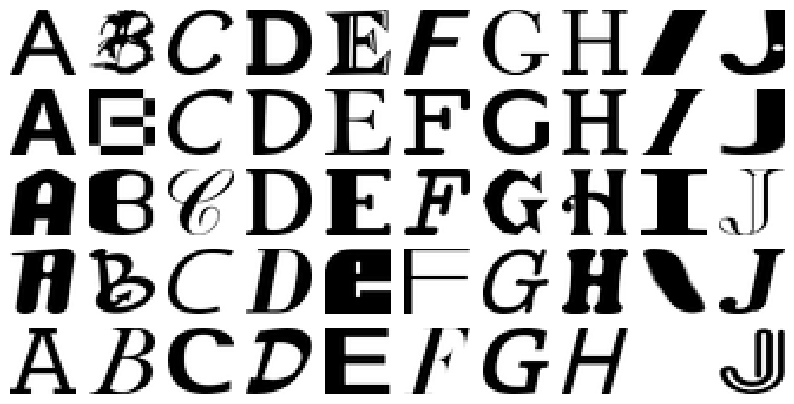

In [58]:
rows = 5
fig, axes = plt.subplots(rows, classes, figsize=(classes,rows))

for letter_id in range(classes) :
    letters = x[y==letter_id]      # 0부터 9까지 각 숫자에 맞는 array가 letters에 들어간다.
    letters_len = len(letters)

    for row_i in range(rows) :
        axe = axes[row_i, letter_id]
        axe.imshow( letters[np.random.randint(letters_len)], cmap='Greys', interpolation='none')
        axe.axis('off')

# 데이터 전처리

### 데이터 나누기
- training set : test set = 8:2
- 재현을 위한 난수 고정 : 2023

In [76]:
x.shape, y.shape

((18724, 28, 28, 1), (18724,))

In [77]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2023)

In [78]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14979, 28, 28, 1), (14979,), (3745, 28, 28, 1), (3745,))

### 데이터 스케일링
- 2차원 이상에서는 sklearn.preprocessing의 MinMaxScaler사용이 어렵다.
- 따라서 전체 값의 Max, min값을 찾아 수작업으로 스케일링을 해줘야한다.

- x값에 대하여 데이터 스케일링 진행한다

In [79]:
max_n, min_n = x_train.max(), x_train.min()
print(max_n, min_n)
x_train = (x_train - min_n) / (max_n - min_n)

255.0 0.0


In [80]:
x_train.max(), x_train.min()

(1.0, 0.0)

In [81]:
max_n, min_n = x_test.max(), x_test.min()
print(max_n, min_n)
x_test = (x_test - min_n) / (max_n - min_n)

255.0 0.0


In [82]:
x_test.max(), x_test.min()

(1.0, 0.0)

### One-Hot Encoding

- y 값(0~9)에 대하여 원핫 인코딩을 한다.

** 주의 to_categorical의 경우 반복실행하면 안된다.(왜냐하면 차원이 늘어나기 때문에**

In [83]:
from tensorflow.keras.utils import to_categorical

In [84]:
np.unique(y_train)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [85]:
class_n = len(np.unique(y_train))

y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)

### Data Shape 재확인

In [86]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

# 모델링 하기
- 조건
    1. Sequential API, Functional API 중 택일
    2. Flatten Layer 사용할 것
    3. Activation Function이 주어진 Dense Layer 뒤에 BatchNormalization 사용할 것
    4. Dropout을 0.2 정도로 사용할 것
    5. Early Stopping을 사용할 것
    
### Functional API
1. 세션 클리어 : 메모리에 기존 모델 구조가 남아 있으면, 정리해줘.
2. 레이어 사슬처럼 엮기
3. 모델의 시작과 끝 지정
4. 컴파일

In [100]:
# 1. 세션 클리어 : 메모리에 기존 모델 구조가 남아 있으면, 정리해줘.
tf.keras.backend.clear_session()

# 2. 레이어 사슬처럼 엮기
il = tf.keras.layers.Input(shape=(28,28,1)) # input layer

hl = tf.keras.layers.Flatten()(il)
hl = tf.keras.layers.Dense(256, activation='relu')(hl)
hl = tf.keras.layers.Dense(256, activation='relu')(hl)
hl = tf.keras.layers.BatchNormalization()(hl)
hl = tf.keras.layers.Dropout(0.2)(hl)

hl = tf.keras.layers.Dense(128, activation='relu')(hl)
hl = tf.keras.layers.Dense(128, activation='relu')(hl)
hl = tf.keras.layers.BatchNormalization()(hl)
hl = tf.keras.layers.Dropout(0.2)(hl)

hl = tf.keras.layers.Dense(64, activation='relu')(hl)
hl = tf.keras.layers.Dense(64, activation='relu')(hl)
hl = tf.keras.layers.BatchNormalization()(hl)
hl = tf.keras.layers.Dropout(0.2)(hl)

ol = tf.keras.layers.Dense(10, activation='softmax')(hl) # output layer

# 3. 모델의 시작과 끝 지정
model = tf.keras.models.Model(il,ol)
# model = tf.keras.Model(il,ol) # 위와 동일

# 4. 컴파일
model.compile(optimizer='adam',
             loss= tf.keras.losses.categorical_crossentropy,
             metrics='accuracy')

# 5. 모델 보기
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [90]:
# 모델 생성
X = tf.keras.Input([28,28,1])
H = tf.keras.layers.Flatten()(X)
H = tf.keras.layers.Dense(64, activation='swish')(H)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Dropout(0.2)(H)
Y = tf.keras.layers.Dense(10, activation='softmax')(H)
model = tf.keras.Model(X,Y)

model.compile(loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                           

### Ealry Stopping

- monitor : earlystopping 적용할 관측 대상
- min_delta : Treshhold. 설정한 값보다 크게 변해야 성능 개선 간주
- patience : 성능 개선이 이루어지지 않을 때, 몇번 더 지켜볼 것인지
- verbose : 어느 epoch에서 earlystopping이 적용되었는지 보여주기
- restore_best_weights : 가장 성능이 좋은 시점의 epoch 가중치로 돌려줌

In [105]:
from tensorflow.keras.callbacks import EarlyStopping
early = EarlyStopping(monitor = 'val_loss',min_delta=0,patience=3, verbose=1,restore_best_weights=True) 


In [91]:
# 위 코드와 동일
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                        min_delta=0,
                                        patience=10,
                                        restore_best_weights=True)

### .fit()

In [107]:
# 모델 학습
result = model.fit(x_train, 
                   y_train,
                  epochs=1000,
                   verbose=1,
                   validation_split=0.2,
                   callbacks=[early]
                  )

Epoch 1/1000
375/375 [==============================] - 4s 7ms/step - loss: 0.8476 - accuracy: 0.7430 - val_loss: 0.4775 - val_accuracy: 0.8611
Epoch 2/1000
375/375 [==============================] - 2s 6ms/step - loss: 0.4865 - accuracy: 0.8606 - val_loss: 0.3950 - val_accuracy: 0.8775
Epoch 3/1000
375/375 [==============================] - 2s 7ms/step - loss: 0.4108 - accuracy: 0.8811 - val_loss: 0.4120 - val_accuracy: 0.8782
Epoch 4/1000
375/375 [==============================] - 2s 6ms/step - loss: 0.3764 - accuracy: 0.8909 - val_loss: 0.3438 - val_accuracy: 0.8949
Epoch 5/1000
375/375 [==============================] - 2s 6ms/step - loss: 0.3406 - accuracy: 0.9007 - val_loss: 0.3765 - val_accuracy: 0.8909
Epoch 6/1000
375/375 [==============================] - 3s 7ms/step - loss: 0.3269 - accuracy: 0.9028 - val_loss: 0.3532 - val_accuracy: 0.9005
Epoch 7/1000
375/375 [==============================] - 3s 7ms/step - loss: 0.2976 - accuracy: 0.9128 - val_loss: 0.3347 - val_accuracy:

### .evaluate()

In [108]:
model.evaluate(x_test, y_test)

118/118 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.9049


[0.32656049728393555, 0.9049399495124817]

### .predict()

In [109]:
y_pred = model.predict(x_test)

118/118 [==============================] - 0s 2ms/step


In [110]:
y_pred[:2] # 0~9까지의 확률값

array([[2.4077446e-04, 1.3614024e-01, 1.7986954e-04, 8.5479152e-01,
        4.5485041e-04, 4.2474666e-04, 6.1682244e-03, 7.4391707e-04,
        6.8210455e-04, 1.7372328e-04],
       [6.4720472e-05, 1.9615134e-05, 1.5820086e-05, 7.1028204e-05,
        8.3729637e-06, 5.4617954e-05, 3.7276131e-05, 1.4337579e-05,
        7.4416940e-04, 9.9897003e-01]], dtype=float32)

In [111]:
# 원핫 인코딩 한 것을 다시 묶어주는 코드
# 평가 지표 및 실제 데이터 확인을 위해 필요

y_pred_arg = np.argmax(y_pred, axis=1) # 가장 높은 값의 인덱스를 반환
y_test_arg = np.argmax(y_test, axis=1)

In [112]:
y_pred_arg

array([3, 9, 1, ..., 1, 0, 1], dtype=int64)

In [113]:
y_test_arg

array([3, 9, 1, ..., 1, 0, 1], dtype=int64)

### 평가지표

In [123]:
from sklearn.metrics import accuracy_score, classification_report

In [124]:
accuracy_score(y_test_arg, y_pred_arg)

0.9049399198931909

In [126]:
print( classification_report(y_test_arg, y_pred_arg) )

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       357
           1       0.88      0.88      0.88       365
           2       0.93      0.92      0.93       374
           3       0.98      0.86      0.92       392
           4       0.93      0.85      0.89       406
           5       0.92      0.95      0.93       377
           6       0.79      0.94      0.86       372
           7       0.88      0.94      0.90       374
           8       0.94      0.87      0.90       385
           9       0.90      0.94      0.92       343

    accuracy                           0.90      3745
   macro avg       0.91      0.91      0.91      3745
weighted avg       0.91      0.90      0.91      3745



# 시각화하기

### 실제 데이터 확인

idx = 1187
해당 인덱스의 이미지는 C
모델의 예측 : C
모델의 클래스별 확률 : 
-------------------
A 0.0
B 0.0
C 99.0
D 0.0
E 0.0
F 0.0
G 0.0
H 0.0
I 0.0
J 0.0
정답


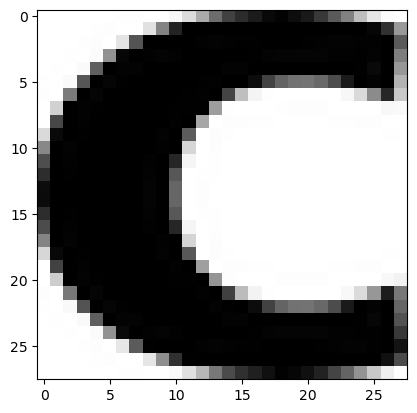

In [127]:
letters_str = "ABCDEFGHIJ"

rand_idx = np.random.randint(0, len(y_pred_arg))
test_idx = y_test_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if y_test_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(x_test[rand_idx], cmap='Greys')
plt.show()

### 틀린 이미지만 확인해보기

In [128]:
temp = (y_test_arg == y_pred_arg)
false_idx = np.where(temp==False)[0]
false_len = len(false_idx)
false_len

356

idx = 1631
해당 인덱스의 이미지는 B
모델의 예측 : G
모델의 클래스별 확률 : 
-------------------
A 2.0
B 5.0
C 2.0
D 4.0
E 5.0
F 1.0
G 67.0
H 2.0
I 5.0
J 1.0
땡


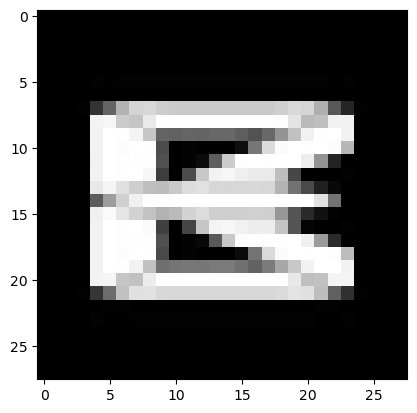

In [133]:
letters_str = "ABCDEFGHIJ"

rand_idx = false_idx[np.random.randint(0, false_len)]
test_idx = y_test_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if y_test_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(x_test[rand_idx], cmap='Greys')
plt.show()